In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from itertools import islice
import time
import matplotlib.pyplot as plt

batch_size = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=True)

### LeNet

Точность без обучения: 9.80%
SGD:
Эпоха: 1, Потери: 0.0022989407221476236
Эпоха: 2, Потери: 0.002249151400725047
Эпоха: 3, Потери: 0.0013261514162023862
Эпоха: 4, Потери: 0.000432143127421538
Эпоха: 5, Потери: 0.00029276984309156733
Точность SGD: 93.11%
Время обучения: 98.24794459342957 с

AdaDelta:
Эпоха: 1, Потери: 0.0013916583066185316
Эпоха: 2, Потери: 0.0002936000943183899
Эпоха: 3, Потери: 0.0001627071913331747
Эпоха: 4, Потери: 0.0001139081014941136
Эпоха: 5, Потери: 8.601456557710965e-05
Точность AdaDelta: 97.94%
Время обучения: 102.56018900871277 с

NAG:
Эпоха: 1, Потери: 0.0023006178379058836
Эпоха: 2, Потери: 0.002282354482014974
Эпоха: 3, Потери: 0.0018206407358249029
Эпоха: 4, Потери: 0.0004926668837666511
Эпоха: 5, Потери: 0.0003184354561070601
Точность NAG: 92.01%
Время обучения: 99.95705914497375 с

Adam:
Эпоха: 1, Потери: 0.0006603813466926415
Эпоха: 2, Потери: 0.00012828512365619342
Эпоха: 3, Потери: 8.044285184393327e-05
Эпоха: 4, Потери: 6.161415862540404e-05
Эпоха:

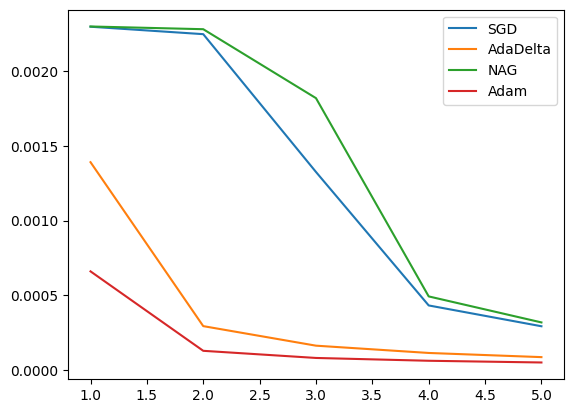

In [27]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 256)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net0 = LeNet().to(device)
net = LeNet().to(device)
criterion = nn.CrossEntropyLoss()

def resetNet():
    net.load_state_dict(net0.state_dict())

def countAccuracy():
    correct = 0
    size = len(testloader)
    for image, label in islice(testloader, size):
        image, label = image.to(device), label.to(device)
        output = net(image)
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == label).sum().item()
    return 100 * correct / len(testset)

def train(optimizer, optim_name):
    print(f"{optim_name}:")
    start_time = time.time()
    xs, ys = [], []
    batch_num = len(trainloader)
    for epoch in range(5):
        running_loss = 0.0
        for inputs, labels in islice(trainloader, batch_num):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        xs.append(epoch + 1)
        ys.append(running_loss / len(trainset))
        print(f'Эпоха: {xs[-1]}, Потери: {ys[-1]}')
    plt.plot(xs, ys, label = optim_name)
    print(f"Точность {optim_name}: {countAccuracy():.2f}%")
    print(f"Время обучения: {time.time() - start_time} с\n")

resetNet()
print(f"Точность без обучения: {countAccuracy():.2f}%")
SGD = optim.SGD(net.parameters(), lr=0.1)
train(SGD, "SGD")
resetNet()
AdaDelta = optim.Adadelta(net.parameters(), lr=1.0)
train(AdaDelta, "AdaDelta")
resetNet()
NAG = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, nesterov=True)
train(NAG, "NAG")
resetNet()
Adam = optim.Adam(net.parameters(), lr=0.005)
train(Adam, "Adam")

plt.legend()
plt.show()

In [3]:
print(torch.cuda.is_available())

True
